## Установка зависимостей

In [1]:
!pip install nemo_toolkit[asr]
!pip install adabelief_pytorch
!pip install jiwer
!pip install lion_pytorch
!pip install python-Levenshtein

import os

import nemo
import nemo.collections.asr as nemo_asr
from nemo.core.optim.novograd import Novograd
from nemo.collections.asr.modules import AudioToMelSpectrogramPreprocessor
from omegaconf import OmegaConf, DictConfig

import numpy as np
import scipy as scp
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torchaudio.functional as Fa
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingWarmRestarts
from nemo.core.optim.lr_scheduler import CosineAnnealing
from pytorch_lightning.utilities.types import LRSchedulerConfig
from lion_pytorch import Lion
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from adabelief_pytorch import AdaBelief

import librosa
from sklearn.model_selection import train_test_split as tts

from tqdm import tqdm
import editdistance
import jiwer
import Levenshtein

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 55.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 845.4/845.4 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 38.

## Импорт датасетов и пример визуализации

In [2]:
DATA_DIR = "/kaggle/input/morsedataset"
AUDIO_DIR = f"{DATA_DIR}/morse_dataset/morse_dataset"
train_data = pd.read_csv(f"{DATA_DIR}/train.csv")
test_data = pd.read_csv(f"{DATA_DIR}/test.csv")

In [3]:
# Preprocessing
def loadAudio(path):
    waveform, _ = librosa.load(path, sr=16000)
    return waveform

def domFreq(waveform, sr=16000):
    fft = np.fft.rfft(waveform)
    frequencies = np.fft.rfftfreq(len(waveform), d=1/sr)
    peak_freq = frequencies[np.argmax(np.abs(fft))]
    return peak_freq

def computeMelSpectrogram(waveform, sr=16000, n_fft=512, hop_length=160, n_mels=64, 
                          top_db=15, amin=1e-6):
    peak_freq = domFreq(waveform)
    S = librosa.feature.melspectrogram(
        y=waveform,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    S_dB = librosa.power_to_db(S, ref=np.max, top_db=top_db, amin=amin)
    S_dB = (S_dB - S_dB.min()) / (S_dB.max() - S_dB.min())
    return S_dB**3

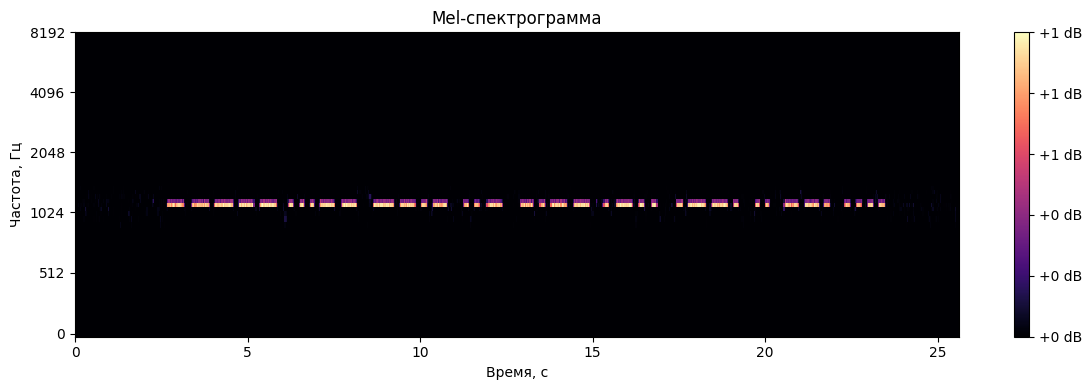

In [4]:
plt.figure(figsize=(12, 4))
waveform = loadAudio(f"{AUDIO_DIR}/1.opus")
S_dB = computeMelSpectrogram(waveform)

librosa.display.specshow(S_dB, sr=16000, x_axis="time", y_axis="mel")

plt.colorbar(format="%+2.0f dB")
plt.title("Mel-спектрограмма")
plt.xlabel("Время, с")
plt.ylabel("Частота, Гц")
plt.tight_layout()
plt.show()

## Реализация архитектуры

In [5]:
class SineVolumeModulation(nn.Module):
    def __init__(self, min_volume=0.3, max_volume=1.0, freq=0.5, p=0.5):
        super().__init__()
        self.min = min_volume
        self.max = max_volume
        self.freq = freq
        self.p = p

    def forward(self, waveform):
        if torch.rand(1) > self.p:
            return waveform
            
        # Генерация синусоидальной модуляции
        t = torch.arange(len(waveform)) / 16000  # Предполагаем sample_rate=16000
        modulation = self.min + 0.5*(self.max-self.min)*(1 + torch.sin(2*np.pi*self.freq*t))
        
        # Применяем к waveform (учет многоканальности)
        return waveform * modulation.unsqueeze(0).to(waveform.device)

In [6]:
class CustomMelSpectrogramPreprocessor(AudioToMelSpectrogramPreprocessor):
    def __init__(self, peak_freq=None, power=1.0, **kwargs):
        self.peak_freq = peak_freq
        self.power = power
        self._user_features = kwargs.get('features', 64)
        
        # Инициализируем родительский класс
        super().__init__(**kwargs)
        
        # Инициализируем маску частот
        self.freq_mask = None
        self.active_features = self._user_features
        
        if peak_freq is not None:
            self._setup_freq_mask(peak_freq)
    
    def _setup_freq_mask(self, peak_freq):
        self.peak_freq = peak_freq
        
        # Вычисляем границы частот
        sample_rate = self.preprocessor._cfg.sample_rate
        low_bound = max(0, peak_freq - 65)
        high_bound = min(sample_rate // 2, peak_freq + 65)
        
        # Получаем частоты Mel-фильтров
        mel_freqs = librosa.mel_frequencies(
            n_mels=self._user_features,
            fmin=self.preprocessor._cfg.lowfreq,
            fmax=self.preprocessor._cfg.highfreq
        )
        
        # Создаем маску
        self.freq_mask = (mel_freqs >= low_bound) & (mel_freqs <= high_bound)
        self.active_features = sum(self.freq_mask)
        
        print(f"Активных фильтров: {self.active_features}/{self._user_features}")
        
    def forward(self, input_signal, length):
        # Получаем обычную Mel-спектрограмму
        spec, spec_len = super().forward(input_signal=input_signal, length=length)
        
        # Обрезаем по частотам (если задана peak_freq)
        if hasattr(self, 'freq_mask'):
            spec = spec[:, self.freq_mask, :]
            
        # Возводим в степень
        spec = torch.sign(spec) * (torch.abs(spec) ** self.power)
        
        return spec.squeeze(1), spec_len

In [7]:
# Dataset Uploading and Preparing
class MorseDataset(Dataset):
    def __init__(self, data, audio_dir, sample_rate=16000, n_fft=512, hop_length=160, n_mels=64):
        self.data = data
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate
        self.vocab = ["<blank>"] + list("АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ0123456789 #")
        self.char2idx = {char: i for i, char in enumerate(self.vocab)}
        
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels

        self.training = False

    def _create_bandpass_filter(self, lowcut, highcut):
        nyquist = 0.9 * self.sample_rate
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = scp.signal.butter(4, [low, high], btype='band')
        self.filter_coeffs = (b, a)  # Сохраняем коэффициенты фильтра как атрибут класса

    def _apply_bandpass_filter(self, x):
        """Применяет сохраненный bandpass фильтр к сигналу"""
        if hasattr(self, 'filter_coeffs'):
            b, a = self.filter_coeffs
            return scp.signal.filtfilt(b, a, x)
        return x

    def _normalize_waveform(self, waveform):
        # RMS-нормализация
        frame_length = min(8192, len(waveform))
        hop_length = frame_length // 4
        rms = librosa.feature.rms(y=waveform, hop_length=hop_length, frame_length=frame_length)[0]
        gain_rms = 0.9 / (rms + 1e-12)
        gain_rms = np.clip(gain_rms, 2.2, 3.0)  # Ограничение

        # Применим gain покадрово
        y_rms = np.zeros_like(waveform)
        for i in range(len(rms)):
            start = i * 2048
            end = start + 8192
            y_rms[start:end] += waveform[start:end] * gain_rms[i]

        return y_rms / (np.max(np.abs(y_rms)) + 1e-8)

    def _load_and_preprocess(self, waveform):
        """Полный пайплайн предобработки"""
        # self._create_bandpass_filter(lowcut=400, highcut=2500)
        # waveform = self._apply_bandpass_filter(waveform)
        waveform = self._normalize_waveform(waveform)
        return waveform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx] if hasattr(self.data, 'iloc') else self.data[idx]
        
        # Загрузка аудио и преобразование в спектрограмму
        waveform = loadAudio(f"{AUDIO_DIR}/{row['id']}")
        peak_freq = self._find_peak_freq(waveform)
        waveform_pp = self._load_and_preprocess(waveform)
        
        # Преобразование метки в индексы
        label = [self.char2idx[char] for char in row['message']]
        
        return {
            "audio": torch.FloatTensor(waveform_pp),  # [time]
            "audio_len": len(waveform_pp),  # длина аудио
            "labels": torch.LongTensor(label),  # индексы символов
            "labels_len": len(label),  # длина текста
            "peak_freq": peak_freq
        }

    def _find_peak_freq(self, waveform):
        """Определяет доминирующую частоту в сигнале"""
        fft = np.fft.rfft(waveform)
        freqs = np.fft.rfftfreq(len(waveform), d=1/self.sample_rate)
        peak_idx = np.argmax(np.abs(fft))
        return freqs[peak_idx]

In [8]:
# Formatting Func
def morse_collate_fn(batch):
    # Вычисляем максимальные длины для padding
    max_audio_len = max(max(item['audio_len'] for item in batch), 16000)
    max_text_len = max(item['labels_len'] for item in batch)
    
    padded_audio = []
    audio_lengths = []
    padded_text = []
    text_lengths = []
    
    for item in batch:
        # Pad аудио
        audio = item['audio']
        audio_pad = torch.nn.functional.pad(audio, (0, max_audio_len - len(audio)))
        padded_audio.append(audio_pad)
        audio_lengths.append(item['audio_len'])
        
        # Pad текста
        text = item['labels']
        text_pad = torch.nn.functional.pad(text, (0, max_text_len - len(text)), value=0)
        padded_text.append(text_pad)
        text_lengths.append(item['labels_len'])
    
    return {
        "audio": torch.stack(padded_audio),  # [batch, max_time]
        "audio_len": torch.LongTensor(audio_lengths),
        "labels": torch.stack(padded_text),  # [batch, max_text_len]
        "labels_len": torch.LongTensor(text_lengths)
    }

In [9]:
class MorseQuartzNet(pl.LightningModule):
    def __init__(self, steps_per_epoch, base_model=None, freeze_encoder_at_start=False):
        super().__init__()

        # Режим
        self.training_mode = False
        
        self.steps_per_epoch = steps_per_epoch
        self.freeze_encoder_flag = freeze_encoder_at_start

        # Загружаем предобученную модель
        if base_model is not None:
            self.model = base_model
        else:
            self.model = nemo_asr.models.EncDecCTCModel.from_pretrained("stt_ru_quartznet15x5")

        # Изменение YAML-конфига модели
        # 1. Препроцессор
        self.model.preprocessor = CustomMelSpectrogramPreprocessor(
            peak_freq=None,  # Пиковая частота вашего сигнала
            power=3.0,            # Степень возведения
            sample_rate=16000,
            window_size=0.015,
            window_stride=0.01,
            n_fft=512,
            features=64,
            log=True,
            dither=1e-5,
            pad_to=16,
            lowfreq=100,          # Минимальная частота
            highfreq=3000        # Максимальная частота
        )

        # 2. Аугментации
        self.model.spec_augment = nemo_asr.modules.SpectrogramAugmentation(
            rect_freq=8,    # rect_freq
            rect_time=16,    # rect_time 
            rect_masks=3,         # rect_masks
        ) if self.training_mode else None

        # 3. Энкодер
        encoder = nemo_asr.modules.ConvASREncoder(
            feat_in=64,
            activation='silu',
            conv_mask=False,
            jasper=[
                {
                    'filters': 128, 'repeat': 1, 'kernel': [5], 'stride': [1],
                    'dilation': [1], 'dropout': 0.0, 'residual': True, 'separable': True
                },
                {
                    'filters': 128, 'repeat': 2, 'kernel': [7], 'stride': [1],
                    'dilation': [1], 'dropout': 0.1, 'residual': True, 'separable': True
                },
                {
                    'filters': 192, 'repeat': 3, 'kernel': [11], 'stride': [1],
                    'dilation': [2], 'dropout': 0.2, 'residual': True, 'separable': True
                },
                {
                    'filters': 192, 'repeat': 2, 'kernel': [11], 'stride': [1],
                    'dilation': [1], 'dropout': 0.1, 'residual': True, 'separable': True
                },
                {
                    'filters': 256, 'repeat': 1, 'kernel': [11], 'stride': [1],
                    'dilation': [1], 'dropout': 0.1, 'residual': True, 'separable': False
                }
            ]
        )
        self.model.encoder = encoder

        # 3. Декодер
        self.vocab = ["<blank>"] + list("АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ0123456789 #")
        self.blank_idx = 0
        self.model.decoder = nemo_asr.modules.ConvASRDecoder(
            feat_in=256,
            num_classes=len(self.vocab),
            vocabulary=self.vocab
        )

        self.loss = nn.CTCLoss(blank=self.blank_idx, reduction='mean', zero_infinity=False)

        if freeze_encoder_at_start:
            self.freeze_encoder()

    def forward(self, input_signal, input_signal_length, peak_freq=None):
        if peak_freq is not None:
            # Обновляем маску частот
            avg_freq = torch.mean(peak_freq).item()
            self.model.preprocessor._setup_freq_mask(avg_freq)
            
            # Обновляем размерность в энкодере
            active_features = self.model.preprocessor.active_features
            self.model.encoder.feat_in = active_features
        
        return self.model(input_signal=input_signal, input_signal_length=input_signal_length)

    def tokens_to_text(self, tokens):
        return ''.join([
            self.vocab[t] for t in tokens
            if t != self.blank_idx and 0 <= t < len(self.vocab)
        ])

    def training_step(self, batch, batch_idx):
        inputs = batch["audio"]
        input_lengths = batch["audio_len"]
        targets = batch["labels"]
        target_lengths = batch["labels_len"]
        peak_freq = batch.get("peak_freq")

        logits, logits_lengths, _ = self.forward(input_signal=inputs, input_signal_length=input_lengths, peak_freq=peak_freq)
        
        log_probs = torch.log_softmax(logits, dim=-1)
        loss = self.loss(
            log_probs.permute(1, 0, 2),  # (time, batch, classes)
            targets,
            logits_lengths,
            target_lengths
        )
        
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        self.training_mode = False
        inputs = batch["audio"]
        input_lengths = batch["audio_len"]
        targets = batch["labels"]
        target_lengths = batch["labels_len"]
        peak_freq = batch.get("peak_freq")
    
        logits, logit_lengths, _ = self.forward(input_signal=inputs, input_signal_length=input_lengths, peak_freq=peak_freq)
        log_probs = torch.log_softmax(logits, dim=-1)
    
        loss = self.loss(
            log_probs.permute(1, 0, 2),
            targets,
            logit_lengths,
            target_lengths
        )
    
        pred_tokens = torch.argmax(log_probs, dim=-1)
        pred_texts = []
        for i, tokens in enumerate(pred_tokens):
            pred_texts.append(self.tokens_to_text(tokens[:logit_lengths[i]].cpu().numpy().tolist()))
    
        target_texts = []
        for i in range(len(targets)):
            target_seq = targets[i][:target_lengths[i]]
            target_texts.append(self.tokens_to_text(target_seq.cpu().numpy().tolist()))
    
        # CER
        cer = sum(jiwer.cer(t, p) for t, p in zip(target_texts, pred_texts)) / len(target_texts)
    
        # Levenshtein distance
        lev_distances = [Levenshtein.distance(t, p) for t, p in zip(target_texts, pred_texts)]
        mean_levenshtein = sum(lev_distances) / len(lev_distances)
    
        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_CER", cer, prog_bar=True, logger=True)
        self.log("val_Lev", mean_levenshtein, prog_bar=True, logger=True)
    
        return {
            "val_loss": loss,
            "val_CER": cer,
            "val_Lev": mean_levenshtein,
        }

    def predict_step(self, batch, batch_idx):
        inputs = batch["audio"]
        input_lengths = batch["audio_len"]
        ids = batch.get("id", [f"sample_{i}" for i in range(len(inputs))])
        peak_freq = batch.get("peak_freq")

        logits, logit_lengths, _ = self.forward(input_signal=inputs, input_signal_length=input_lengths, peak_freq=peak_freq)
        log_probs = torch.log_softmax(logits, dim=-1)
        pred_tokens = torch.argmax(log_probs, dim=-1)

        results = []
        for i, tokens in enumerate(pred_tokens):
            tokens = tokens[:logit_lengths[i]].cpu().numpy().tolist()
            text = self.tokens_to_text(tokens)
            results.append({"id": ids[i], "message": text})

        return results

    def configure_optimizers(self):
        # Оптимизатор AdaBelief (лучше адаптируется к шуму в градиентах)
        optimizer = AdaBelief(
            self.parameters(),
            lr=1e-3,                  # Стартовый LR
            betas=(0.9, 0.999),       # Стандартные беты
            eps=1e-8,
            weight_decay=1e-5,         # Слабее, чем у вас сейчас (5e-5)
            rectify=False              # Для совместимости с OneCycleLR
        )
    
        # Шедулер OneCycleLR
        scheduler = {
            'scheduler': OneCycleLR(
                optimizer,
                max_lr=5e-3,           # Пиковый LR (может быть выше стартового)
                total_steps=self.trainer.estimated_stepping_batches,  # Автоматический расчёт
                pct_start=0.1,         # 10% эпох на разогрев (warmup)
                anneal_strategy='cos', # Плавное снижение по косинусу
                div_factor=25,         # Начальный LR = max_lr / 25 (3e-4 / 25 = 1.2e-5)
                final_div_factor=1e4   # Финальный LR = max_lr / 1e4 (3e-8)
            ),
            'interval': 'step',       # Обновление на каждом шаге (не эпохе)
            'name': 'lr_scheduler'
        }
    
        return [optimizer], [scheduler]

    # Замораживание encoder'а
    def freeze_encoder(self):
        for param in self.model.encoder.parameters():
            param.requires_grad = False
        self.freeze_encoder_flag = True
        print("Encoder frozen.")

    # Размораживание encoder'а
    def unfreeze_encoder(self):
        for param in self.model.encoder.parameters():
            param.requires_grad = True
        self.freeze_encoder_flag = False
        print("Encoder unfrozen.")

In [10]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

train = train_data
train, val = tts(train, test_size=0.15, random_state=42)

train_dataset = MorseDataset(train, AUDIO_DIR)
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    collate_fn=morse_collate_fn,
    shuffle=True,
    num_workers=4,
    worker_init_fn=seed_worker,
    generator=torch.Generator().manual_seed(42)
)

val_dataset = MorseDataset(val, AUDIO_DIR)
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    collate_fn=morse_collate_fn,
    shuffle=False,
    num_workers=2,
    worker_init_fn=seed_worker,
    generator=torch.Generator().manual_seed(42)
)

In [11]:
class EncoderUnfreezeCallback(pl.Callback):
    def __init__(self, unfreeze_at_epoch=2):
        self.unfreeze_at_epoch = unfreeze_at_epoch

    def on_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch == self.unfreeze_at_epoch and pl_module.freeze_encoder_flag:
            pl_module.unfreeze_encoder()

In [12]:
pl.seed_everything(42, workers=True)

# Инициализация модели
# ckpt = "/kaggle/input/qn_ru_pt2/pytorch/default/1/quartznet_pre_weights.ckpt"
# base_model = nemo_asr.models.EncDecCTCModel.restore_from("/kaggle/input/qn_ru_pt/pytorch/default/1/quartznet10x5.nemo")
base_model = None
model = MorseQuartzNet(
    steps_per_epoch=len(train_loader),
    base_model=base_model,
    freeze_encoder_at_start=False  # Флаг заморозки энкодера
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_CER",          # Имя метрики (должно возвращаться в validation_step)
    mode="min",                # Минимизировать CER (для WER тоже "min")
    save_top_k=1,              # Сохранять только 1 лучшую модель
    dirpath="/kaggle/working/",  # Папка для чекпоинтов
    filename="best_{epoch}-{val_CER:.3f}"
)

[NeMo I 2025-04-22 01:48:46 nemo_logging:393] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_ru_quartznet15x5/versions/1.0.0rc1/files/stt_ru_quartznet15x5.nemo to /root/.cache/torch/NeMo/NeMo_2.2.1/stt_ru_quartznet15x5/92506570b7206ea395e295b3fbbf07e3/stt_ru_quartznet15x5.nemo
[NeMo I 2025-04-22 01:48:47 nemo_logging:393] Instantiating model from pre-trained checkpoint


[NeMo W 2025-04-22 01:48:49 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /raid/noneval.json
    sample_rate: 16000
    labels:
    - ' '
    - а
    - б
    - в
    - г
    - д
    - е
    - ё
    - ж
    - з
    - и
    - й
    - к
    - л
    - м
    - н
    - о
    - п
    - р
    - с
    - т
    - у
    - ф
    - х
    - ц
    - ч
    - ш
    - щ
    - ъ
    - ы
    - ь
    - э
    - ю
    - я
    batch_size: 16
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: null
    num_workers: 8
    pin_memory: true
    
[NeMo W 2025-04-22 01:48:49 nemo_logging:405] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the val

[NeMo I 2025-04-22 01:48:49 nemo_logging:393] PADDING: 16
[NeMo I 2025-04-22 01:48:50 nemo_logging:393] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.2.1/stt_ru_quartznet15x5/92506570b7206ea395e295b3fbbf07e3/stt_ru_quartznet15x5.nemo.
[NeMo I 2025-04-22 01:48:50 nemo_logging:393] PADDING: 16


In [ ]:
trainer = pl.Trainer(
    callbacks=[
        checkpoint_callback
    ],
    max_epochs=50,
    accelerator='auto',
    devices='auto',
    precision="16-mixed",
    enable_progress_bar=True
)

trainer.fit(model, train_loader, val_loader)

2025-04-22 01:48:53.811585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745286534.239296      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745286534.358414      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
model_path = "/kaggle/working/weights_test.ckpt"
trainer.save_checkpoint(model_path)

## Инференс

In [ ]:
# Dataset Uploading and Preparing
class TestMorseDataset(Dataset):
    def __init__(self, data, audio_dir, sample_rate=16000, n_fft=512, hop_length=160, n_mels=64):
        self.data = data
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate
        self.vocab = list("АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ0123456789 #") + ["<blank>"]
        self.char2idx = {char: i for i, char in enumerate(self.vocab)}
        
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels

        self.training = False

        # Bandpass фильтр
        self.bandpass_filter = self._create_bandpass_filter(500, 3000)

    def _create_bandpass_filter(self, lowcut, highcut):
        nyquist = 0.5 * self.sample_rate
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = scp.signal.butter(4, [low, high], btype='band')
        self.filter_coeffs = (b, a)  # Сохраняем коэффициенты фильтра как атрибут класса

    def _apply_bandpass_filter(self, x):
        if hasattr(self, 'filter_coeffs'):
            b, a = self.filter_coeffs
            return scp.signal.filtfilt(b, a, x)
        return x  # Если фильтр не инициализирован, возвращаем исходный сигнал

    def _normalize_waveform(self, waveform):
        return waveform / (np.max(np.abs(waveform)) + 1e-8)

    def _load_and_preprocess(self, waveform):
        waveform = self._apply_bandpass_filter(waveform)
        waveform = self._normalize_waveform(waveform)
        return waveform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx] if hasattr(self.data, 'iloc') else self.data[idx]
        
        waveform = loadAudio(f"{self.audio_dir}/{row['id']}")
        waveform_pp = self._load_and_preprocess(waveform)
    
        return {
            "id": row["id"],  # <-- добавь это
            "audio": torch.FloatTensor(waveform_pp),
            "audio_len": len(waveform_pp),
        }

def test_collate_fn(batch):
    max_audio_len = max(item['audio_len'] for item in batch)
    padded_audio = []
    audio_lengths = []
    ids = []
    for item in batch:
        audio = item['audio']
        padded = F.pad(audio, (0, max_audio_len - len(audio)))
        padded_audio.append(padded)
        audio_lengths.append(item['audio_len'])
        ids.append(item['id'])
    return {
        "id": ids,
        "audio": torch.stack(padded_audio),
        "audio_len": torch.LongTensor(audio_lengths),
    }

In [ ]:
test_dataset = TestMorseDataset(test_data, AUDIO_DIR)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    collate_fn=test_collate_fn,
    shuffle=False,
    num_workers=4,
    worker_init_fn=seed_worker,
    generator=torch.Generator().manual_seed(42)
)

In [ ]:
pl.seed_everything(42, workers=True)
base_model = None
ckpt = "/kaggle/input/qn_best/pytorch/default/1/best_epoch17-val_cer0.000.ckpt"
model = MorseQuartzNet.load_from_checkpoint(
    ckpt,
    steps_per_epoch=len(train_loader),
    base_model=base_model,
    freeze_encoder_at_start=False  # Флаг заморозки энкодера
)

In [ ]:
trainer = pl.Trainer(accelerator="auto", devices="auto")
predictions = trainer.predict(model, dataloaders=test_loader)

In [ ]:
flat_preds = [pred for batch in predictions for pred in batch]
test_data["message"] = flat_preds
test_data[["id", "message"]].to_csv("/kaggle/working/output_csv", index=False)